In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                        # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules
#mse_values = 0
#mse_count = 0
def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0
    def predict_node_state(x_hat, delta_t):
        return A @ x_hat
    
    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes, previously_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return (top_nodes | currently_polled_nodes) - previously_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes, previously_polled_nodes)

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(x_hat, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1
            #print(f'the mse value  is {mse_values}')

            if abs(measured_value - predicted_measurement) > theta:
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': predicted_measurement,
                    'time_elapsed': delta_t
                })

            currently_polled_nodes.add(mote)

        previously_polled_nodes = top_sensors

        for mote in top_sensors:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    #average_mse = mse_values / mse_count
    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    # Generate plot for distribution of polled over transmitted counts for each node
    ratios = {mote: transmitted_count[mote] / polled_count[mote]  if transmitted_count[mote] > 0 else 0 for mote in polled_count}



    return average_mse, average_lifetime_years

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 530.5684612765771
  Average sensor lifetime (years): 3.588273976708198
Nodes to poll: 2
  Average MSE: 628.5116272093883
  Average sensor lifetime (years): 3.5172170659586093
Nodes to poll: 5
  Average MSE: 706.2047928788825
  Average sensor lifetime (years): 3.3043085536884336
Nodes to poll: 10
  Average MSE: 744.9098229155851
  Average sensor lifetime (years): 2.9489516433490275
Nodes to poll: 20
  Average MSE: 759.3546033724468
  Average sensor lifetime (years): 2.2317970552077395


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                        # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def predict_node_state(x_hat, delta_t):
        A_delta = np.array([[1, delta_t], [0, 1]])  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat
    
    def select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        nodes_to_poll = []
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = H @ state_estimates[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        nodes_to_poll.sort(key=lambda mote: np.trace(P[mote]), reverse=True)
        return nodes_to_poll[:num_nodes_to_poll]
    
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 13.244858447164036
  Average sensor lifetime (years): 2.426830006950177
Nodes to poll: 2
  Average MSE: 9.84742329336105
  Average sensor lifetime (years): 1.6328521576839434
Nodes to poll: 5
  Average MSE: 6.563515307439826
  Average sensor lifetime (years): 0.8756124281730636
Nodes to poll: 10
  Average MSE: 6.562593748062222
  Average sensor lifetime (years): 0.8790421734382592
Nodes to poll: 20
  Average MSE: 6.736261248852938
  Average sensor lifetime (years): 0.8730111392072692


Running simulation for 1 nodes to poll...


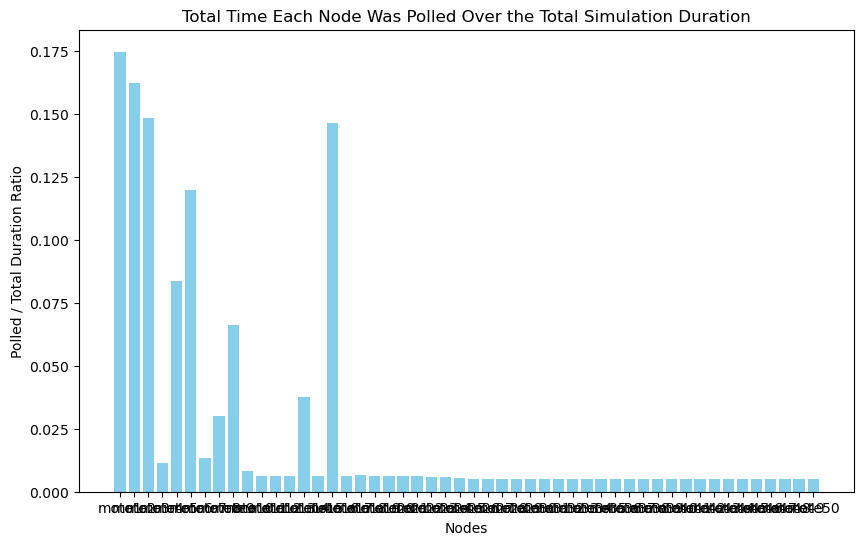

Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...


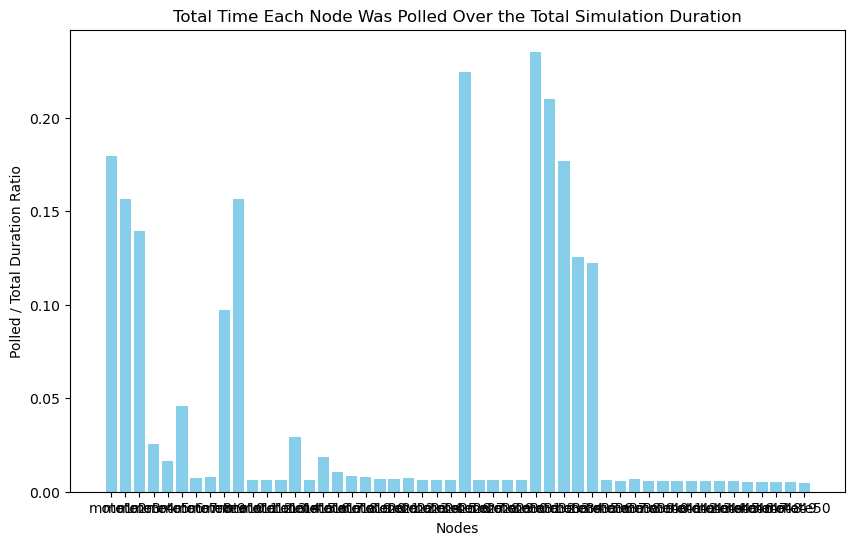

Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...


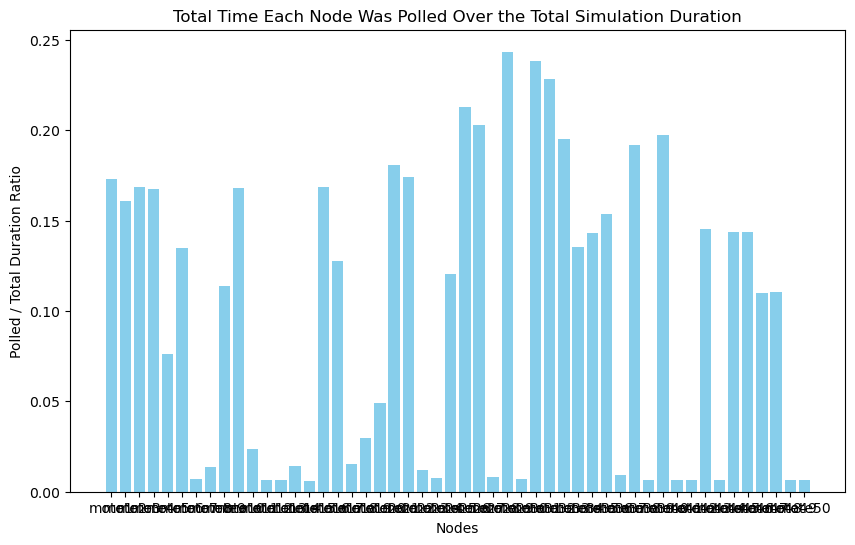

Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...


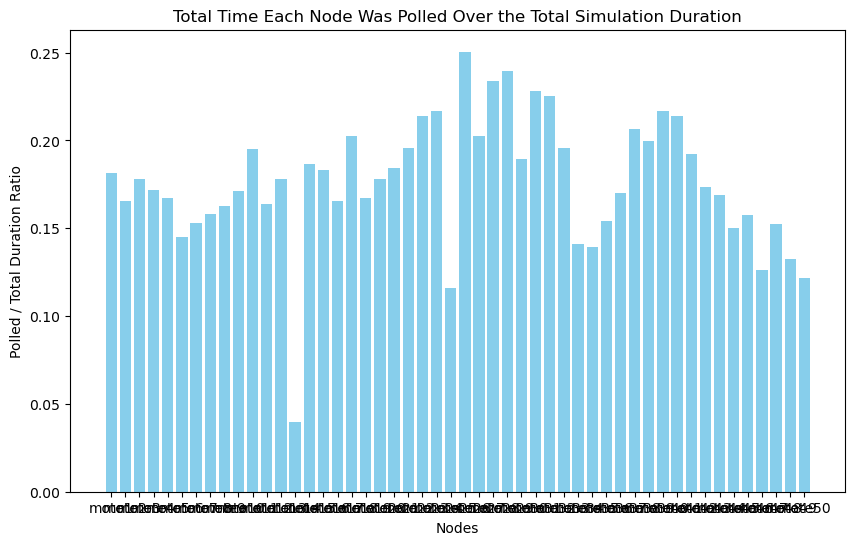

Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...


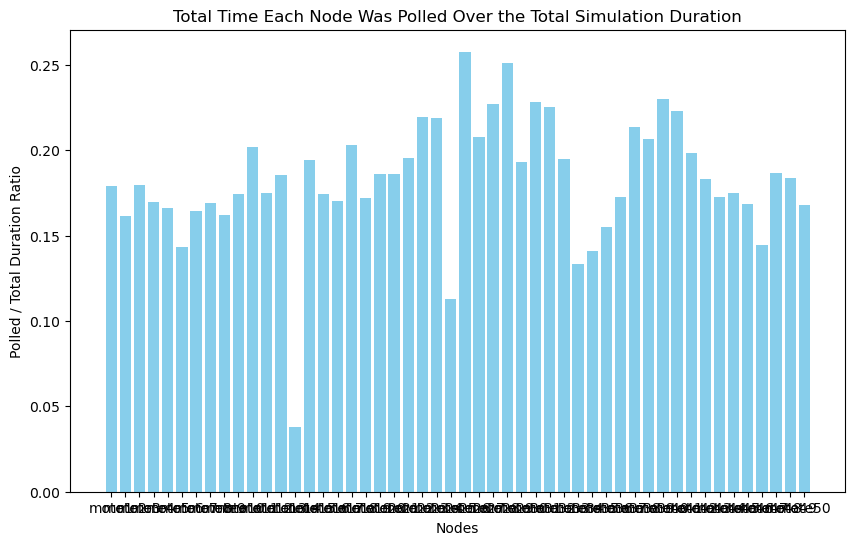

Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 9.70042968129262
  Average sensor lifetime (years): 2.923958451807594
Nodes to poll: 2
  Average MSE: 6.586987266093575
  Average sensor lifetime (years): 2.4728344188491245
Nodes to poll: 5
  Average MSE: 4.109984915698087
  Average sensor lifetime (years): 1.3593567592150912
Nodes to poll: 10
  Average MSE: 2.2025558330241033
  Average sensor lifetime (years): 0.3277738536697607
Nodes to poll: 20
  Average MSE: 2.230055064537424
  Average sensor lifetime (years): 0.31721427002562097


NameError: name 'polled_count' is not defined

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.1                       # Sensitivity threshold for event detection
theta = 0.1                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def predict_node_state(x_hat, delta_t):
        A_delta = np.array([[1, delta_t], [0, 1]])  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat
    
    def select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        nodes_to_poll = []
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = H @ state_estimates[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        nodes_to_poll.sort(key=lambda mote: np.trace(P[mote]), reverse=True)
        return nodes_to_poll[:num_nodes_to_poll]
    
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    # Generate plot for total time each node was polled over the total simulation duration
    total_duration = len(pivot_df)
    ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

    plt.figure(figsize=(10, 6))
    plt.bar(ratios.keys(), ratios.values(), color='skyblue')
    plt.xlabel('Nodes')
    plt.ylabel('Polled / Total Duration Ratio')
    plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
    plt.show()

    return average_mse, average_lifetime_years

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 11.282317680336256
  Average sensor lifetime (years): 3.0317322824716024
Nodes to poll: 2
  Average MSE: 7.282560908879622
  Average sensor lifetime (years): 2.413921942435083
Nodes to poll: 5
  Average MSE: 4.617484340877745
  Average sensor lifetime (years): 1.039948236626772
Nodes to poll: 10
  Average MSE: 3.329969101224801
  Average sensor lifetime (years): 0.5553136792403323
Nodes to poll: 20
  Average MSE: 3.3243221603314677
  Average sensor lifetime (years): 0.5536511781641646


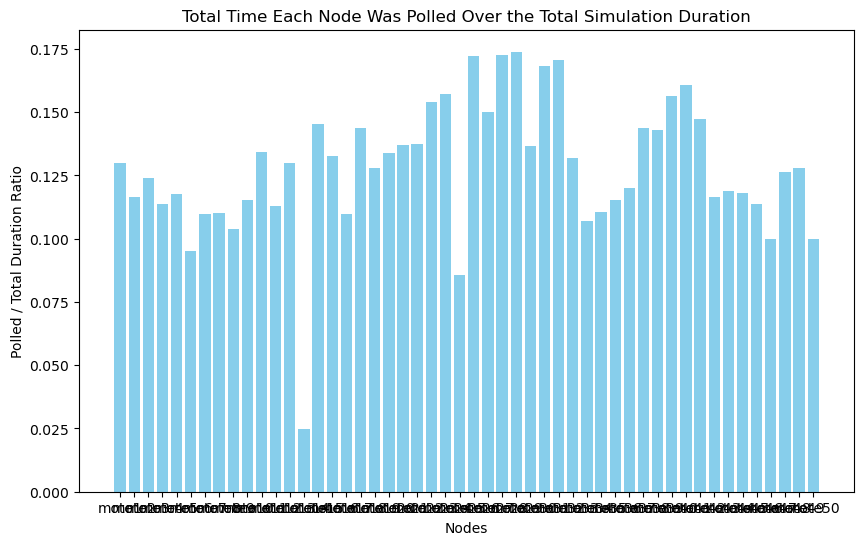

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.2                        # Sensitivity threshold for event detection
theta = 0.2                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def predict_node_state(x_hat, delta_t):
        A_delta = np.array([[1, delta_t], [0, 1]])  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat
    
    def select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        nodes_to_poll = []
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = H @ state_estimates[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        nodes_to_poll.sort(key=lambda mote: np.trace(P[mote]), reverse=True)
        return nodes_to_poll[:num_nodes_to_poll]
    
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s +  E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, polled_count, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, polled_count, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 32.9438121388697
  Average sensor lifetime (years): 3.7808256563466336
Nodes to poll: 2
  Average MSE: 30.143928861984502
  Average sensor lifetime (years): 3.7350059728082674
Nodes to poll: 5
  Average MSE: 22.53094293693649
  Average sensor lifetime (years): 3.584927809963676
Nodes to poll: 10
  Average MSE: 14.929429731000878
  Average sensor lifetime (years): 3.3041693569373187
Nodes to poll: 20
  Average MSE: 10.190315483612363
  Average sensor lifetime (years): 2.7905114685344823


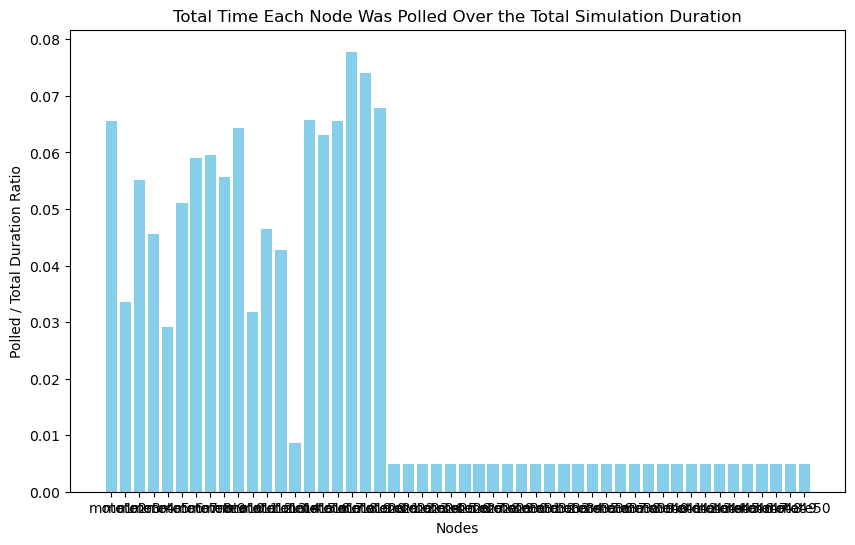

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                        # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()


    def predict_node_state(x_hat, delta_t):
        A_delta = np.array([[1, delta_t], [0, 1]])  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        # Select top M nodes based on the covariance trace
        nodes_by_trace = sorted(state_estimates.keys(), key=lambda mote: np.trace(P[mote]), reverse=True)
        top_m_nodes = nodes_by_trace[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = H @ state_estimates[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            #diff = abs(predicted_measurement - measured_value)

          
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s +  E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, polled_count, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, polled_count, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 17.40127652943985
  Average sensor lifetime (years): 3.7068852823208633
Nodes to poll: 2
  Average MSE: 15.83144774914622
  Average sensor lifetime (years): 3.5765316269790106
Nodes to poll: 5
  Average MSE: 13.44374039482382
  Average sensor lifetime (years): 3.338628711948501
Nodes to poll: 10
  Average MSE: 11.116227045709145
  Average sensor lifetime (years): 3.091183473344855
Nodes to poll: 20
  Average MSE: 9.291921926473064
  Average sensor lifetime (years): 2.554668257253458


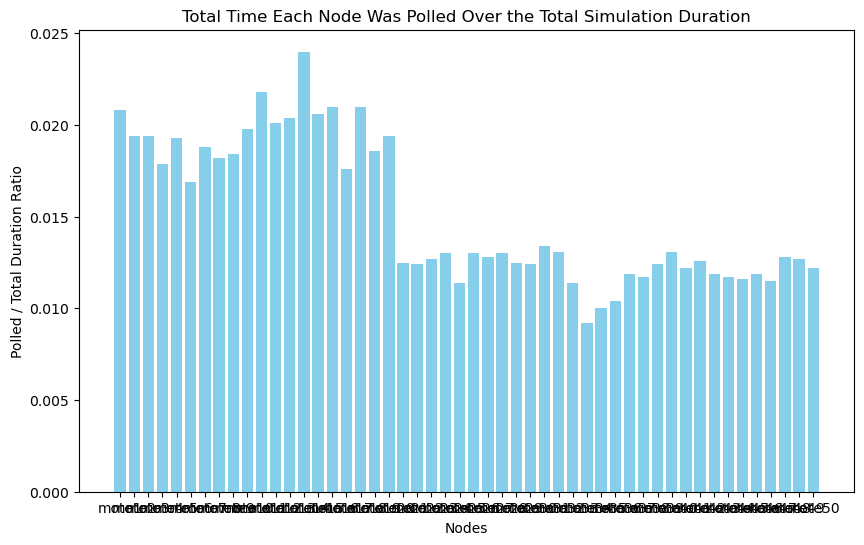

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
A = np.array([[1, 1], [0, 1]])       # State transition matrix with delta_t=32 seconds
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                        # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
        return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[25], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def predict_node_state(x_hat, delta_t):
        A_delta = np.array([[1, delta_t], [0, 1]])  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        # Select top M nodes based on the covariance trace
        nodes_by_trace = sorted(state_estimates.keys(), key=lambda mote: np.trace(P[mote]), reverse=True)
        top_m_nodes = nodes_by_trace[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s +  E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, polled_count, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, polled_count, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 12.923289706157396
  Average sensor lifetime (years): 3.7042852619343547
Nodes to poll: 2
  Average MSE: 12.61318270976848
  Average sensor lifetime (years): 3.6169805437247495
Nodes to poll: 5
  Average MSE: 10.40832214930424
  Average sensor lifetime (years): 3.407614677514347
Nodes to poll: 10
  Average MSE: 8.165879244308064
  Average sensor lifetime (years): 3.157709302529326
Nodes to poll: 20
  Average MSE: 6.282030989737051
  Average sensor lifetime (years): 2.573745555534299


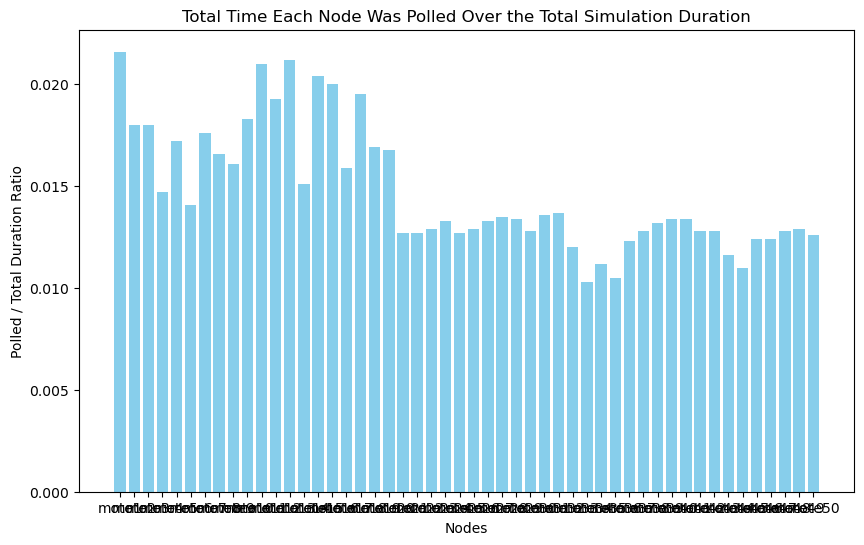

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                        # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def get_state_transition_matrix(delta_t):
        return np.array([[1, delta_t], [0, 1]])

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        # Select top M nodes based on the covariance trace
        nodes_by_trace = sorted(state_estimates.keys(), key=lambda mote: np.trace(P[mote]), reverse=True)
        top_m_nodes = nodes_by_trace[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s +  E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, polled_count, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, polled_count, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 8.66522613347611
  Average sensor lifetime (years): 3.6983179824924792
Nodes to poll: 2
  Average MSE: 5.917533423385398
  Average sensor lifetime (years): 3.608411576724032
Nodes to poll: 5
  Average MSE: 3.495659484071852
  Average sensor lifetime (years): 3.3774457394235733
Nodes to poll: 10
  Average MSE: 2.315249483285541
  Average sensor lifetime (years): 3.014613095741853
Nodes to poll: 20
  Average MSE: 1.3903222151220545
  Average sensor lifetime (years): 2.3386149420433666


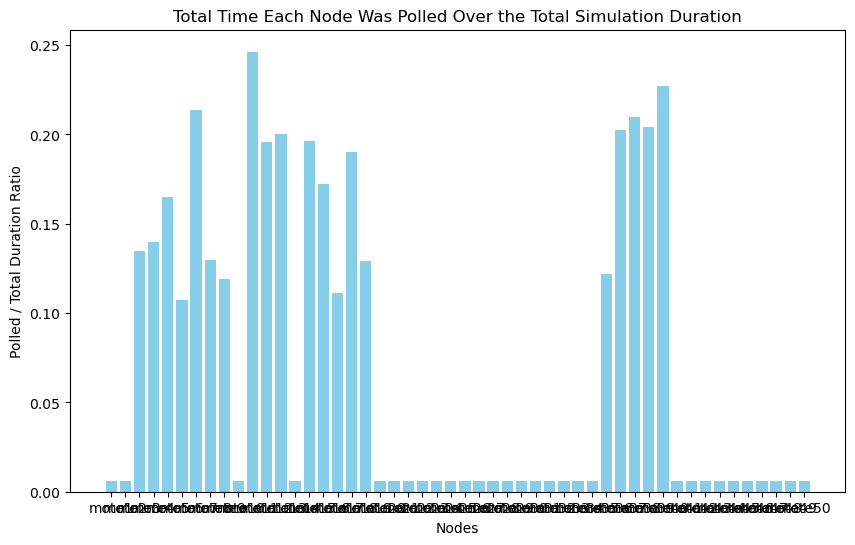

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.1                        # Sensitivity threshold for event detection
theta = 0.1                         # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
force_pull_threshold = 200             # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    accumulated_covariance = {f'mote{i}': 0 for i in range(1, 51)}
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    previously_polled_nodes = set()
    mse_count = 0
    mse_values = 0

    def get_state_transition_matrix(delta_t):
        return np.array([[1, delta_t], [0, 1]])

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def ucb_score(mean, n, total_pulls, alpha):
        if n == 0:
            return float('inf')
        return mean + alpha * np.sqrt(np.log(total_pulls) / n)

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        # Calculate UCB scores
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb_score(accumulated_covariance[mote], polled_count[mote], total_pulls, alpha)
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Update accumulated covariance
            accumulated_covariance[mote] += np.trace(P_hat)

            # Set covariance matrix of the polled sensor to zero
            #P[mote] = np.zeros_like(P[mote])

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, polled_count, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, polled_count, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total time each node was polled over the total simulation duration
total_duration = len(pivot_df)
ratios = {mote: polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Total Duration Ratio')
plt.title('Total Time Each Node Was Polled Over the Total Simulation Duration')
plt.show()


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Running simulation for 50 nodes to poll...
Completed simulation for 50 nodes to poll.
Nodes to poll: 1
  Average MSE: 59.836624087452975
  Average sensor lifetime (years): 3.445244766842432
Nodes to poll: 2
  Average MSE: 54.21919105222264
  Average sensor lifetime (years): 3.323322067839463
Nodes to poll: 5
  Average MSE: 39.50420816918568
  Average sensor lifetime (years): 3.0506601657423946
Nodes to poll: 10
  Average MSE: 29.958530048215806
  Average sensor lifetime (years): 2.7001058233208943
Nodes to poll: 20
  Average MSE: 22.058638050466264
  Average sensor life

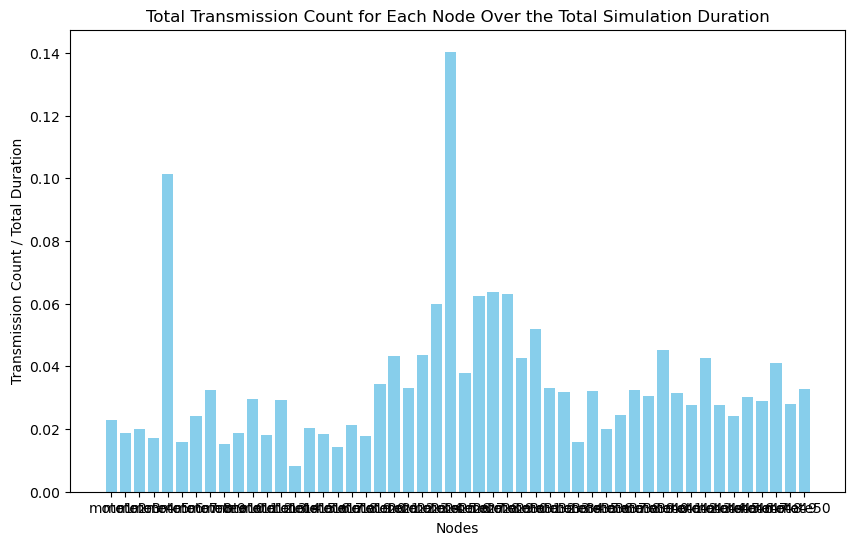

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.5                         # Sensitivity threshold for event detection
theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20,50]  # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    
    mse_count = 0
    mse_values = 0
    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Update the bandit arm
            #bandit_arms[mote].update(np.trace(P_hat))
            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            bandit_arms[mote].update(diff)

            
            

            if not math.isnan(diff):
                mse_values += diff
                mse_count += 1

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, transmitted_count

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {mote: transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Transmission Count / Total Duration')
plt.title('Total Transmission Count for Each Node Over the Total Simulation Duration')
plt.show()


In [20]:
pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
pivot_df['mote50'].mean()

40.31389486037017

Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 3.8399154458934253
  Average sensor lifetime (years): 3.3668191447578524
Nodes to poll: 2
  Average MSE: 5.592990280801315
  Average sensor lifetime (years): 3.142916304024391
Nodes to poll: 5
  Average MSE: 6.78273386283009
  Average sensor lifetime (years): 2.757233355743301
Nodes to poll: 10
  Average MSE: 6.319836734068858
  Average sensor lifetime (years): 2.385394422824042
Nodes to poll: 20
  Average MSE: 4.441844421670243
  Average sensor lifetime (years): 1.9099886490054125


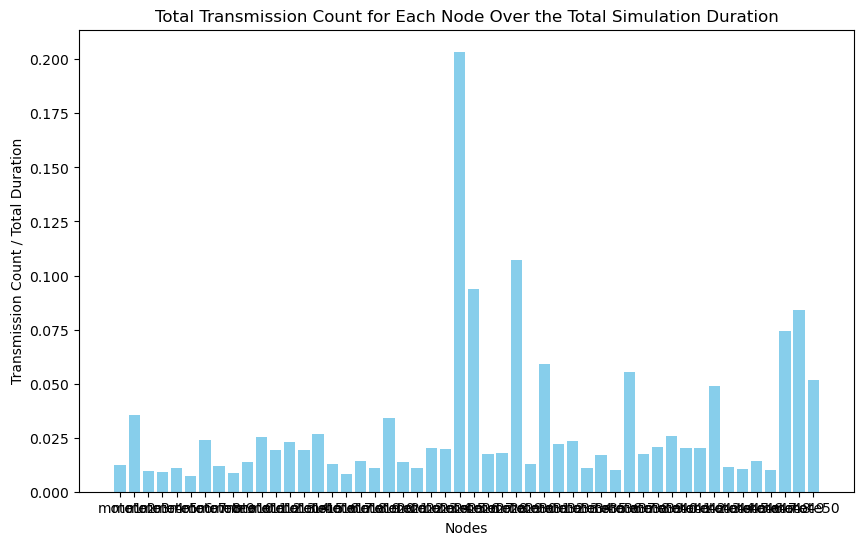

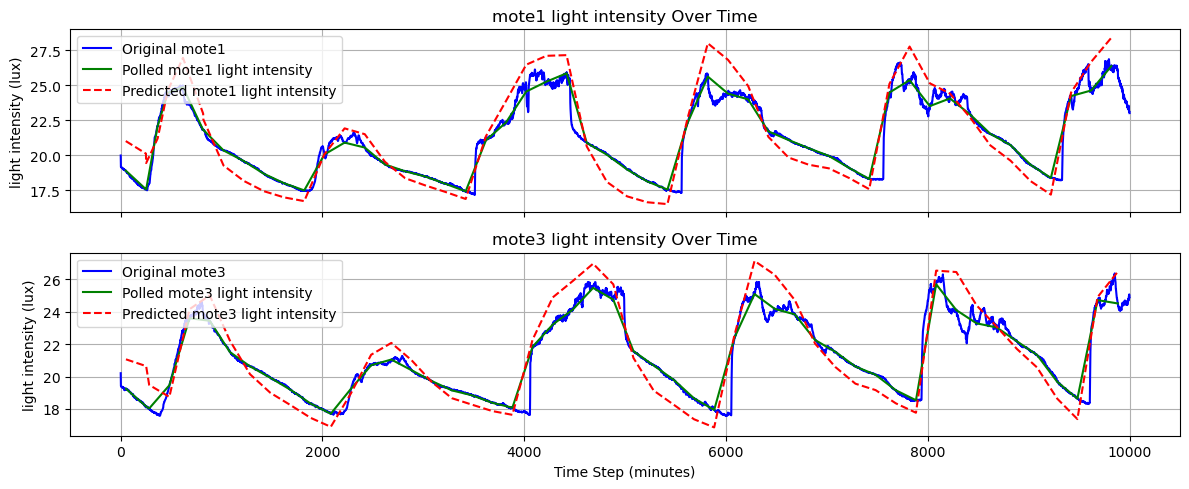

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                   # Measurement noise covariance
epsilon = 0.5                         # Sensitivity threshold for event detection
theta = 0.5                         # Threshold for significant change
num_nodes_to_poll_list = [1,2,5,10,20]  # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    #P = {f'mote{i}': np.eye(2) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    

    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            bandit_arms[mote].update(diff)

            predicted_measurement = predict_node_state(state_estimates[mote], delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'light intensity': measured_value,
                'predicted_light intensity': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['light intensity'] - valuable_sensor_df['predicted_light intensity']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, transmitted_count, valuable_sensor_df

results = {}
valuable_sensor_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {mote: transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Transmission Count / Total Duration')
plt.title('Total Transmission Count for Each Node Over the Total Simulation Duration')
plt.show()

# Plot valuable_sensor_df data for the first simulation
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

num_nodes_to_poll, valuable_sensor_df = valuable_sensor_df_list[0]  # Assuming we want to plot the first simulation's data

for i, mote in enumerate(['mote1', 'mote3']):
    # Plot original data from the node end
    axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
    
    # Plot data collected from the sink end
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['light intensity'], 'g-', label=f'Polled {mote} light intensity')
    axs[i].plot(mote_data['index'], mote_data['predicted_light intensity'], 'r--', label=f'Predicted {mote} light intensity')
    
    axs[i].set_ylabel('light intensity (lux)')
    axs[i].set_title(f'{mote} light intensity Over Time')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 20
  Average MSE: 3.6683185405046226
  Average sensor lifetime (years): 1.2618364649573943


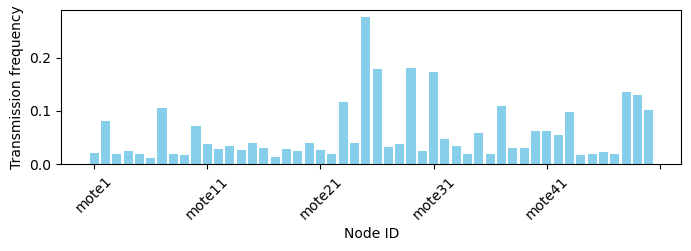

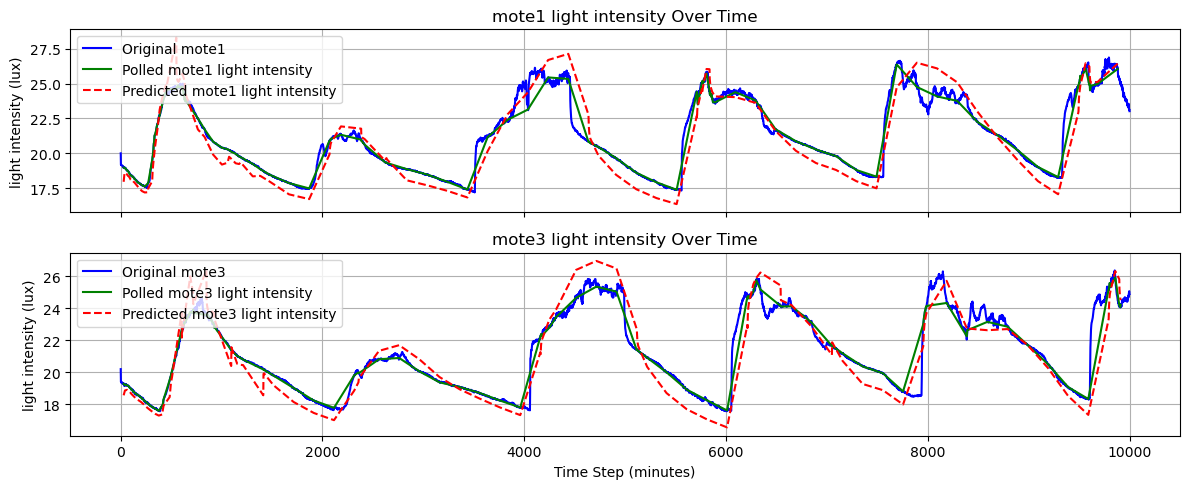

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[2]])                   # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.3                         # Threshold for significant change
num_nodes_to_poll_list = [20]  # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    #P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    P = {f'mote{i}': np.eye(2) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    

    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            bandit_arms[mote].update(diff)

            predicted_measurement = predict_node_state(state_estimates[mote], delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'light intensity': measured_value,
                'predicted_light intensity': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['light intensity'] - valuable_sensor_df['predicted_light intensity']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, transmitted_count, valuable_sensor_df

results = {}
valuable_sensor_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {mote: transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')
#plt.title('Total Transmission Count for Each Node Over the Total Simulation Duration')

# Set x-ticks at intervals of 10
plt.xticks(rotation=45)
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot valuable_sensor_df data for the first simulation
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

num_nodes_to_poll, valuable_sensor_df = valuable_sensor_df_list[0]  # Assuming we want to plot the first simulation's data

for i, mote in enumerate(['mote1', 'mote3']):
    # Plot original data from the node end
    axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
    
    # Plot data collected from the sink end
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['light intensity'], 'g-', label=f'Polled {mote} light intensity')
    axs[i].plot(mote_data['index'], mote_data['predicted_light intensity'], 'r--', label=f'Predicted {mote} light intensity')
    
    axs[i].set_ylabel('light intensity (lux)')
    axs[i].set_title(f'{mote} light intensity Over Time')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 20
  Average MSE: 4.441844421670243
  Average sensor lifetime (years): 1.9099886490054125


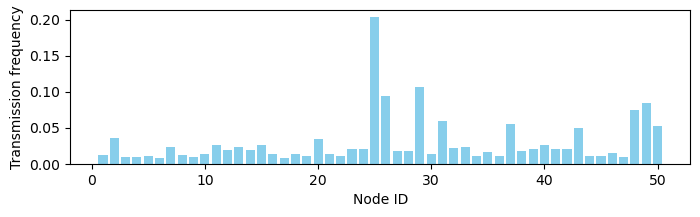

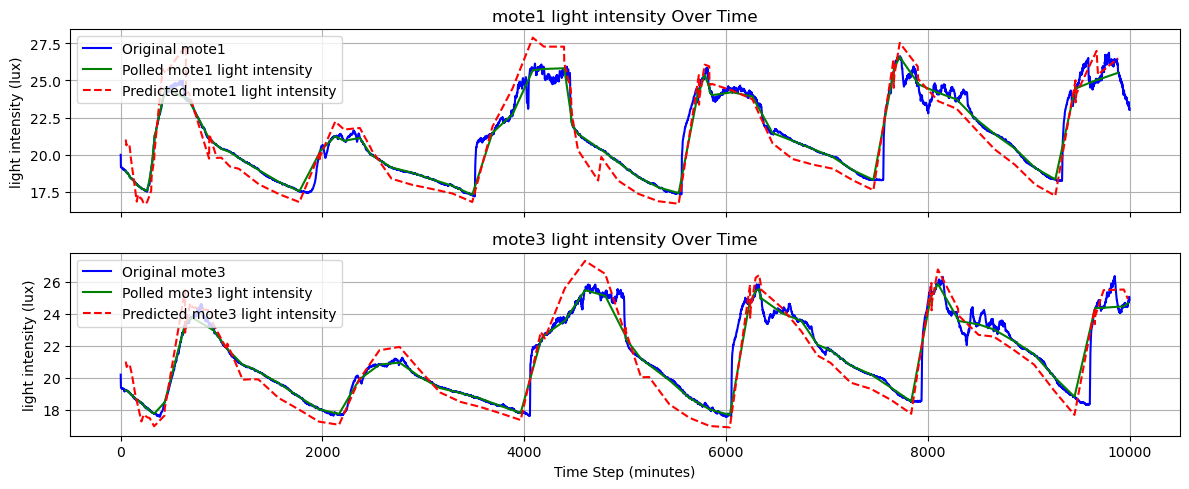

: 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.5                         # Sensitivity threshold for event detection
theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [20]  # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    #P = {f'mote{i}': np.eye(2) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    

    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            bandit_arms[mote].update(diff)

            predicted_measurement = predict_node_state(state_estimates[mote], delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)


            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'light intensity': measured_value,
                'predicted_light intensity': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['light intensity'] - valuable_sensor_df['predicted_light intensity']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, transmitted_count, valuable_sensor_df

results = {}
valuable_sensor_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')
#plt.title('Total Transmission Count for Each Node Over the Total Simulation Duration')

# Set x-ticks at intervals of 10
plt.xticks()
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot valuable_sensor_df data for the first simulation
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

num_nodes_to_poll, valuable_sensor_df = valuable_sensor_df_list[0]  # Assuming we want to plot the first simulation's data

for i, mote in enumerate(['mote1', 'mote3']):
    # Plot original data from the node end
    axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
    
    # Plot data collected from the sink end
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['light intensity'], 'g-', label=f'Polled {mote} light intensity')
    axs[i].plot(mote_data['index'], mote_data['predicted_light intensity'], 'r--', label=f'Predicted {mote} light intensity')
    
    axs[i].set_ylabel('light intensity (lux)')
    axs[i].set_title(f'{mote} light intensity Over Time')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()


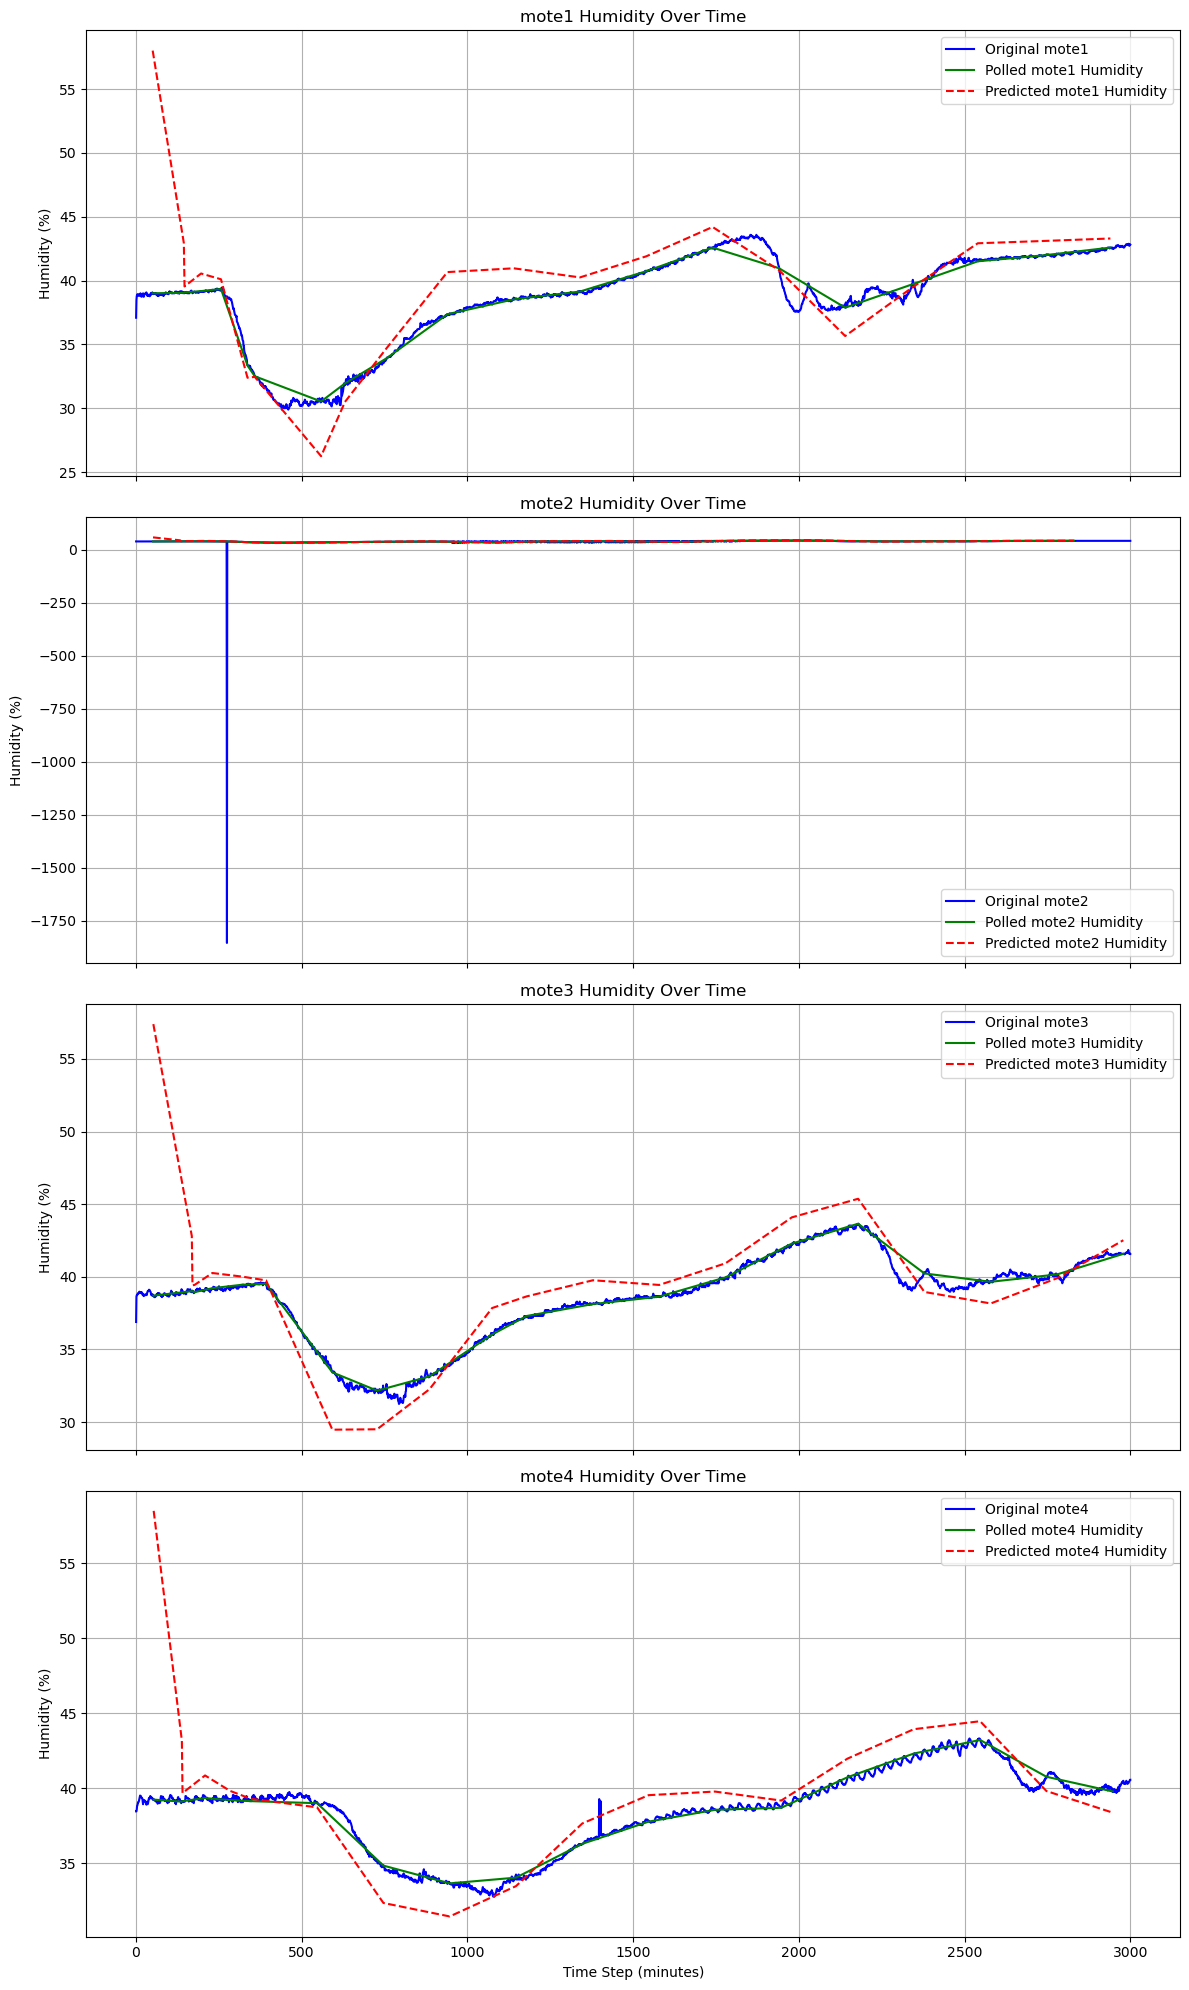

In [32]:
fig, axs = plt.subplots(4, 1, figsize=(12, 20), sharex=True)

for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    # Plot original data from the node end
    axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
    
    # Plot data collected from the sink end
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['humidity'], 'g-', label=f'Polled {mote} Humidity')
    axs[i].plot(mote_data['index'], mote_data['predicted_humidity'], 'r--', label=f'Predicted {mote} Humidity')
    
    axs[i].set_ylabel('Humidity (%)')
    axs[i].set_title(f'{mote} Humidity Over Time')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()